In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import utils
import stock_data_fetcher
from stock_plotter import StockPlotter
from models import Models
from model_evaluator import ModelEvaluator
from time_series_visualizer import TimeSeriesVisualizer
from transformer_model import TimeSeriesTransformer
from lstm_transformer_model import LSTMTransformer
from backtest import BacktestStrategy

from matplotlib.backends.backend_pdf import PdfPages

#To get data from yfinance:
ticker = "AAPL"
start = "2020-01-01"
end = "2025-01-01"
interval = "1d"

stock_fetcher = stock_data_fetcher.StockDataFetcher(ticker, start, end, interval)
stock_data = stock_fetcher.fetch_data()

In [2]:
#To get data from pre-loaded csv file 
ticker = "AAPL"
start = "2024-01-01"
end = "2025-01-01"
stock_data = utils.get_csv(ticker, start, end)
print(stock_data.head()) 
print(ticker)

Loaded stock_data_csv\AAPL_2024-01-01_to_2025-01-01.csv successfully!
         Date     Open     High      Low    Close    Volume
0  2024-01-02  186.032  187.316  182.788  184.532  82983926
1  2024-01-03  183.121  184.771  182.335  183.151  58765173
2  2024-01-04  181.064  181.995  179.799  180.824  72415750
3  2024-01-05  180.904  181.669  179.094  180.099  62754180
4  2024-01-08  180.999  184.492  180.417  184.453  59499566
AAPL


In [3]:
pdf_path = f"results/results_{ticker}_{start}_to_{end}.pdf"
pdf_pages = PdfPages(pdf_path)

df = utils.add_technical_indicators(stock_data)

# Drop NaNs before scaling
df = df.dropna().reset_index(drop=True)

# Prepare data (features + target)
df_scaled, scaler_features, scaler_target = utils.prepare_features(df)

# Create sequences (using the scaled DataFrame)
sequence_length = 15  # Example: 15 days of past data
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')
X, y = utils.create_sequences(df_scaled, target_column='Close', sequence_length=sequence_length)





print("X shape:", X.shape)  # Expected: (num_samples, sequence_length, num_features)
print("y shape:", y.shape)  # Expected: (num_samples,)

print("Original DataFrame (df) Head:\n", df.head(17))
print("Scaled DataFrame (df_scaled) Head:\n", df_scaled.head(17))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X shape: (218, 15, 11)
y shape: (218,)
Original DataFrame (df) Head:
           Date     Open     High      Low    Close     Volume        RSI  \
0   2024-01-30  189.801  190.656  186.351  186.917   56194742  55.828916   
1   2024-01-31  185.924  185.979  183.250  183.299   55800824  46.738493   
2   2024-02-01  182.888  185.834  182.723  185.745   65274972  52.167347   
3   2024-02-02  178.787  186.212  178.181  184.742  103167387  49.885952   
4   2024-02-05  187.026  188.121  184.732  186.561   70087103  56.859138   
5   2024-02-06  185.745  188.181  185.655  188.171   43751872  60.962692   
6   2024-02-07  189.502  189.911  187.486  188.281   53759796  51.604377   
7   2024-02-08  188.256  188.403  186.232  187.196   41207977  42.806093   
8   2024-02-09  187.763  189.098  187.116  187.962   45368429  38.551615   
9   2024-02-12  187.529  187.783  185.912  186.271   41979219  31.775393   
10  2024-02-13  184.897  185.335  182.650  184.170   56796450  29.778131   
11  2024-02-14  18

In [4]:
# Print the first sequence
print("First sequence (X_train[0]):\n", X_train[0])

# Print the last timestep in the first sequence
print("Last timestep in first sequence (X_train[0][-1]):\n", X_train[0][-1])

# Print expected target
print("Expected Next Close Price (y_train[0]):", y_train[0])

# Find the actual row in df_scaled that should match X_train[0][-1]
first_sequence_check = df_scaled.iloc[:15]  # The first 15 rows for comparison
expected_y_train_check = df_scaled.iloc[15]["Close"]  # The expected y_train[0] value

print("First 15 rows from df_scaled:\n", first_sequence_check)
print("Expected y_train[0] from df_scaled:", expected_y_train_check)


First sequence (X_train[0]):
 [[-0.70288783 -0.74008256 -0.7738713   0.24065341 -0.03659284  0.0085382
   0.01886571 -0.04161175 -0.8025111  -0.7842883  -0.7427137 ]
 [-0.8533134  -0.91989034 -0.89505357  0.20240009 -0.04893044 -0.48075542
  -0.16805445 -0.06463023 -0.8017475  -0.7868593  -0.74879754]
 [-0.97110856 -0.9254649  -0.9156479   0.22826178  0.24780196 -0.18854637
  -0.25781432 -0.1023093  -0.80217934 -0.78145045 -0.73726106]
 [-1.1302252  -0.91093266 -1.0931423   0.21765701  1.4346007  -0.31134287
  -0.35622844 -0.15357424 -0.8099172  -0.7732809  -0.71221846]
 [-0.81055635 -0.8375409  -0.8371393   0.2368894   0.39851898  0.06399009
  -0.39009923 -0.20185557 -0.82239157 -0.75980675 -0.6712249 ]
 [-0.86025846 -0.8352342  -0.8010699   0.25391203 -0.42630628  0.28486457
  -0.37821516 -0.23793007 -0.81949854 -0.7520543  -0.6584652 ]
 [-0.71448886 -0.7687242  -0.7295172   0.25507507 -0.11285589 -0.21884833
  -0.3679338  -0.26458308 -0.8179079  -0.74320287 -0.6420559 ]
 [-0.762833 

In [5]:
# Check if the last timestep in X_train[0] corresponds to y_train[0]
print("Last timestep in first sequence (X_train[0][-1]):\n", X_train[0][-1])  # Last row in first sequence
print("Corresponding y_train[0]:", y_train[0])  # Target value


Last timestep in first sequence (X_train[0][-1]):
 [-1.0468451  -1.0893179  -1.0551189   0.17498414 -0.10787112 -1.1531426
 -0.8739702  -0.62256837 -0.8412735  -0.7747092  -0.68143123]
Corresponding y_train[0]: 0.18298794


In [6]:
# Extract the actual closing price from the last timestep in X_train[0]
last_close_price_in_X = X_train[0][-1][df_scaled.columns.get_loc("Close")]

print("Last Close Price in X_train[0][-1]:", last_close_price_in_X)
print("Expected Next Close Price (y_train[0]):", y_train[0])


Last Close Price in X_train[0][-1]: 0.17498414
Expected Next Close Price (y_train[0]): 0.18298794


Backtest results saved to backtest_results.xlsx


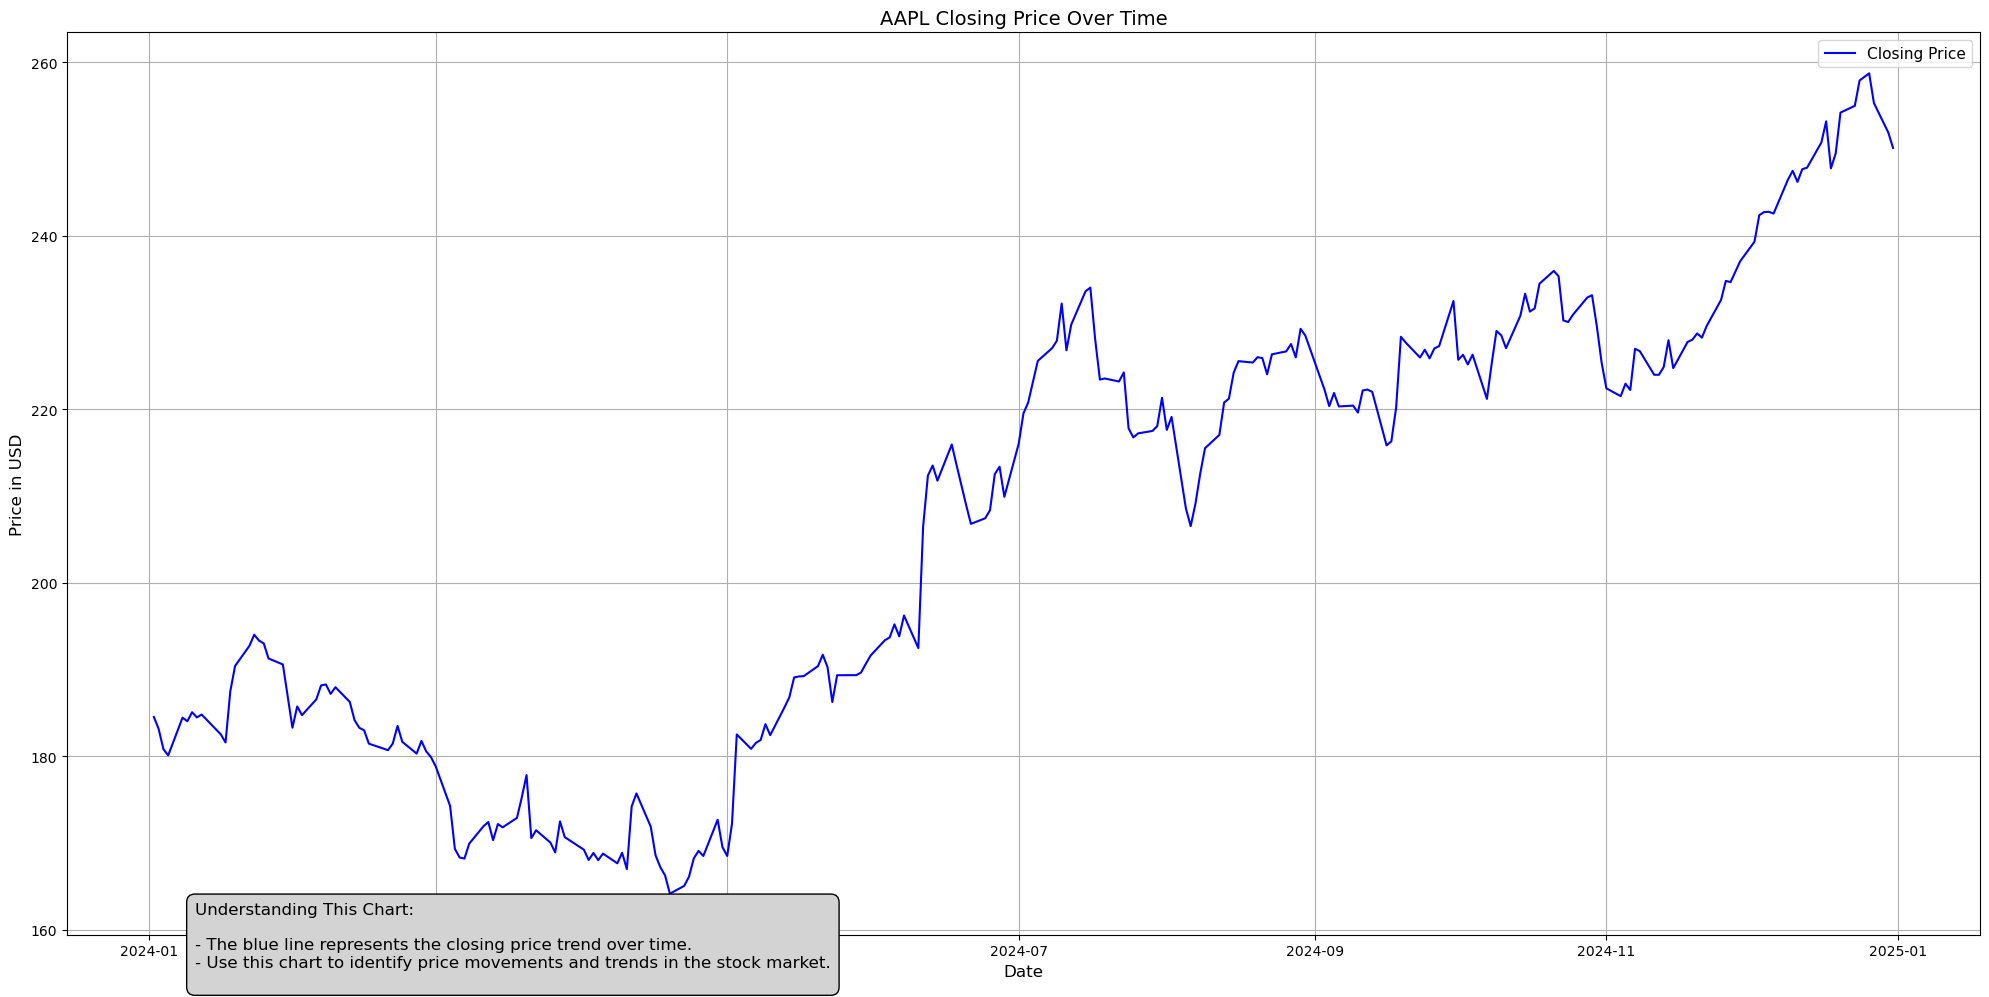

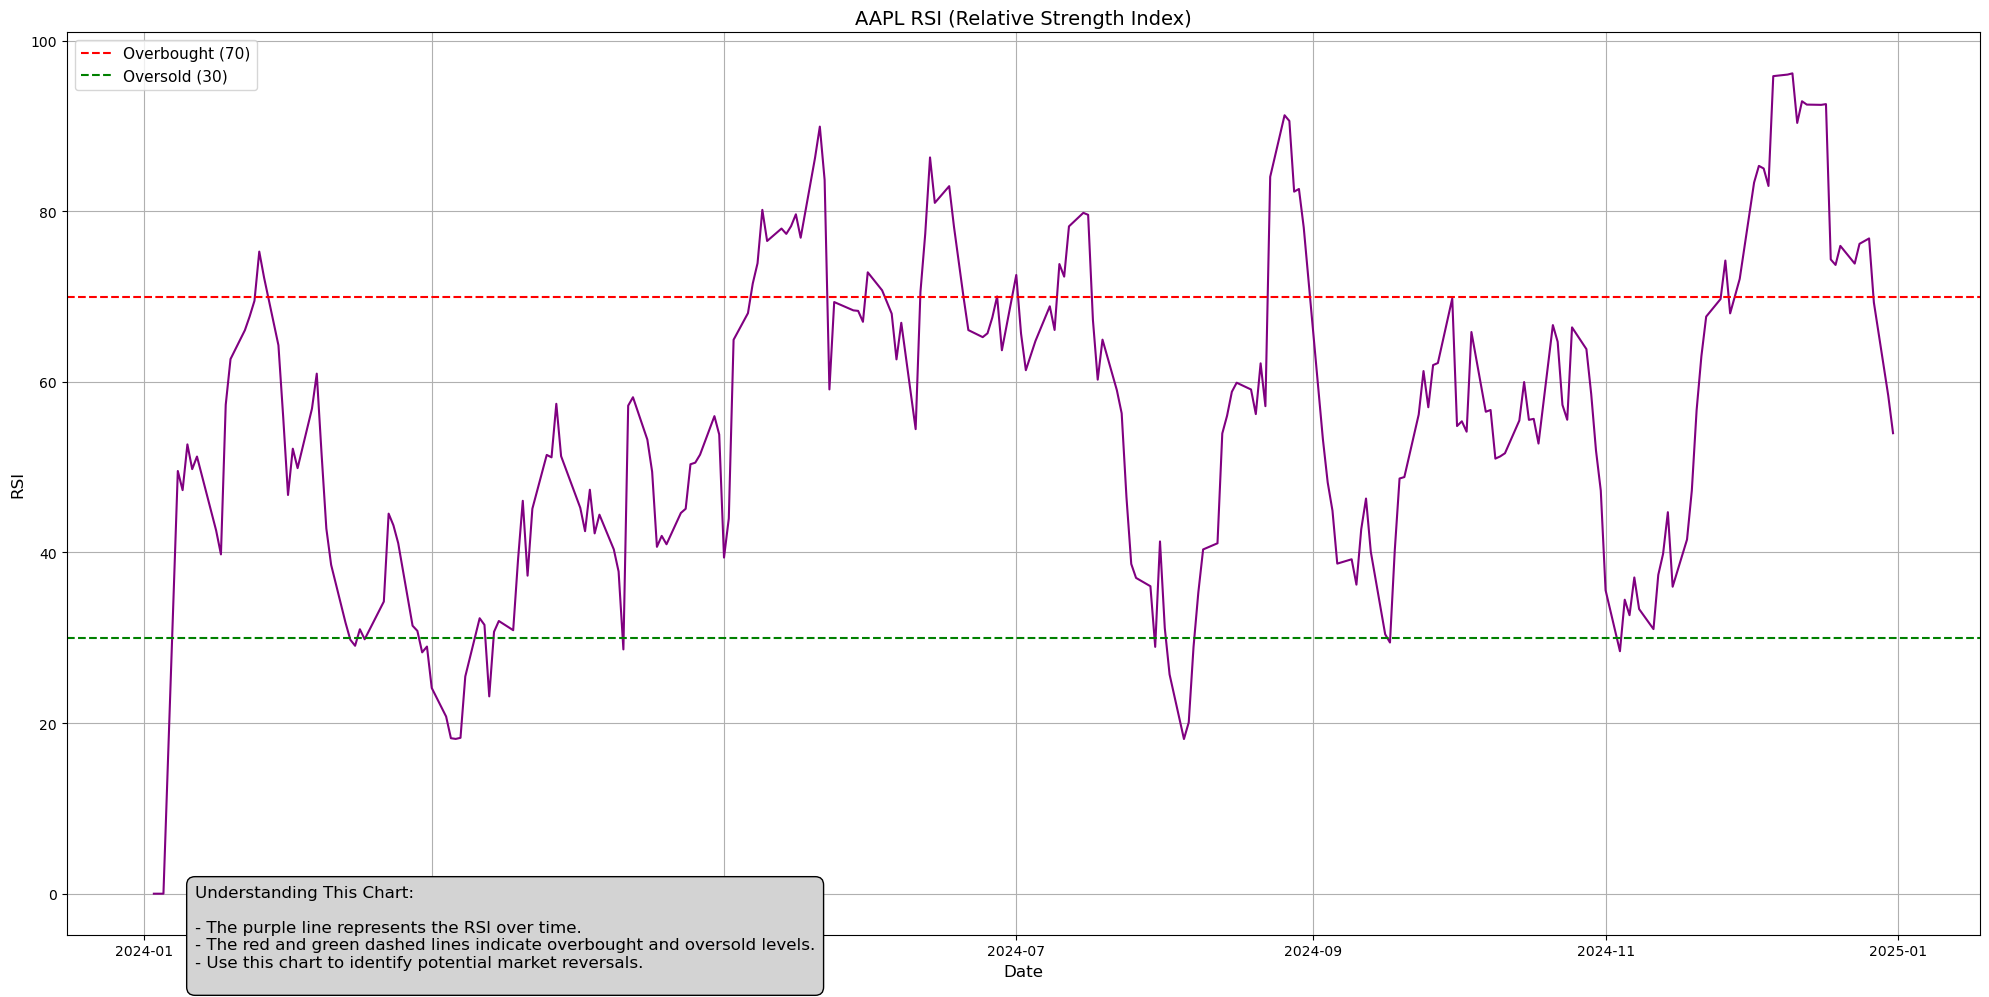

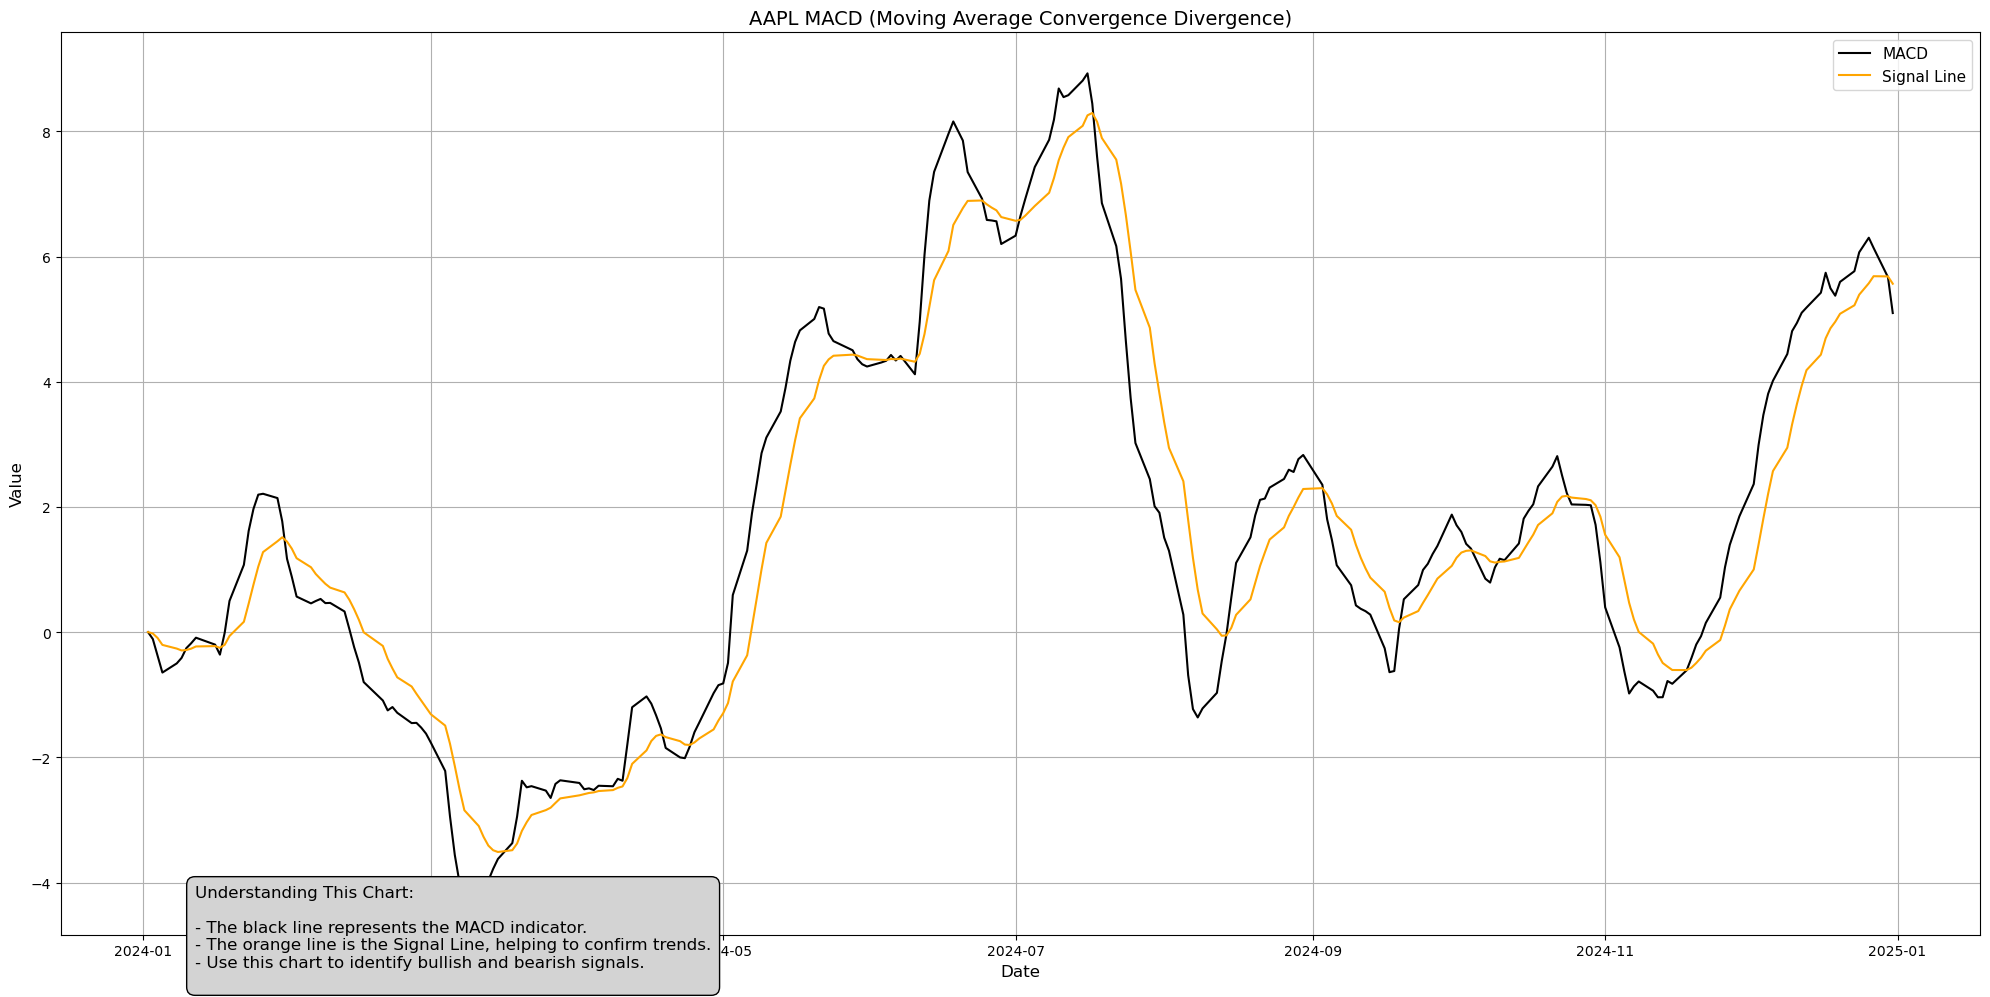

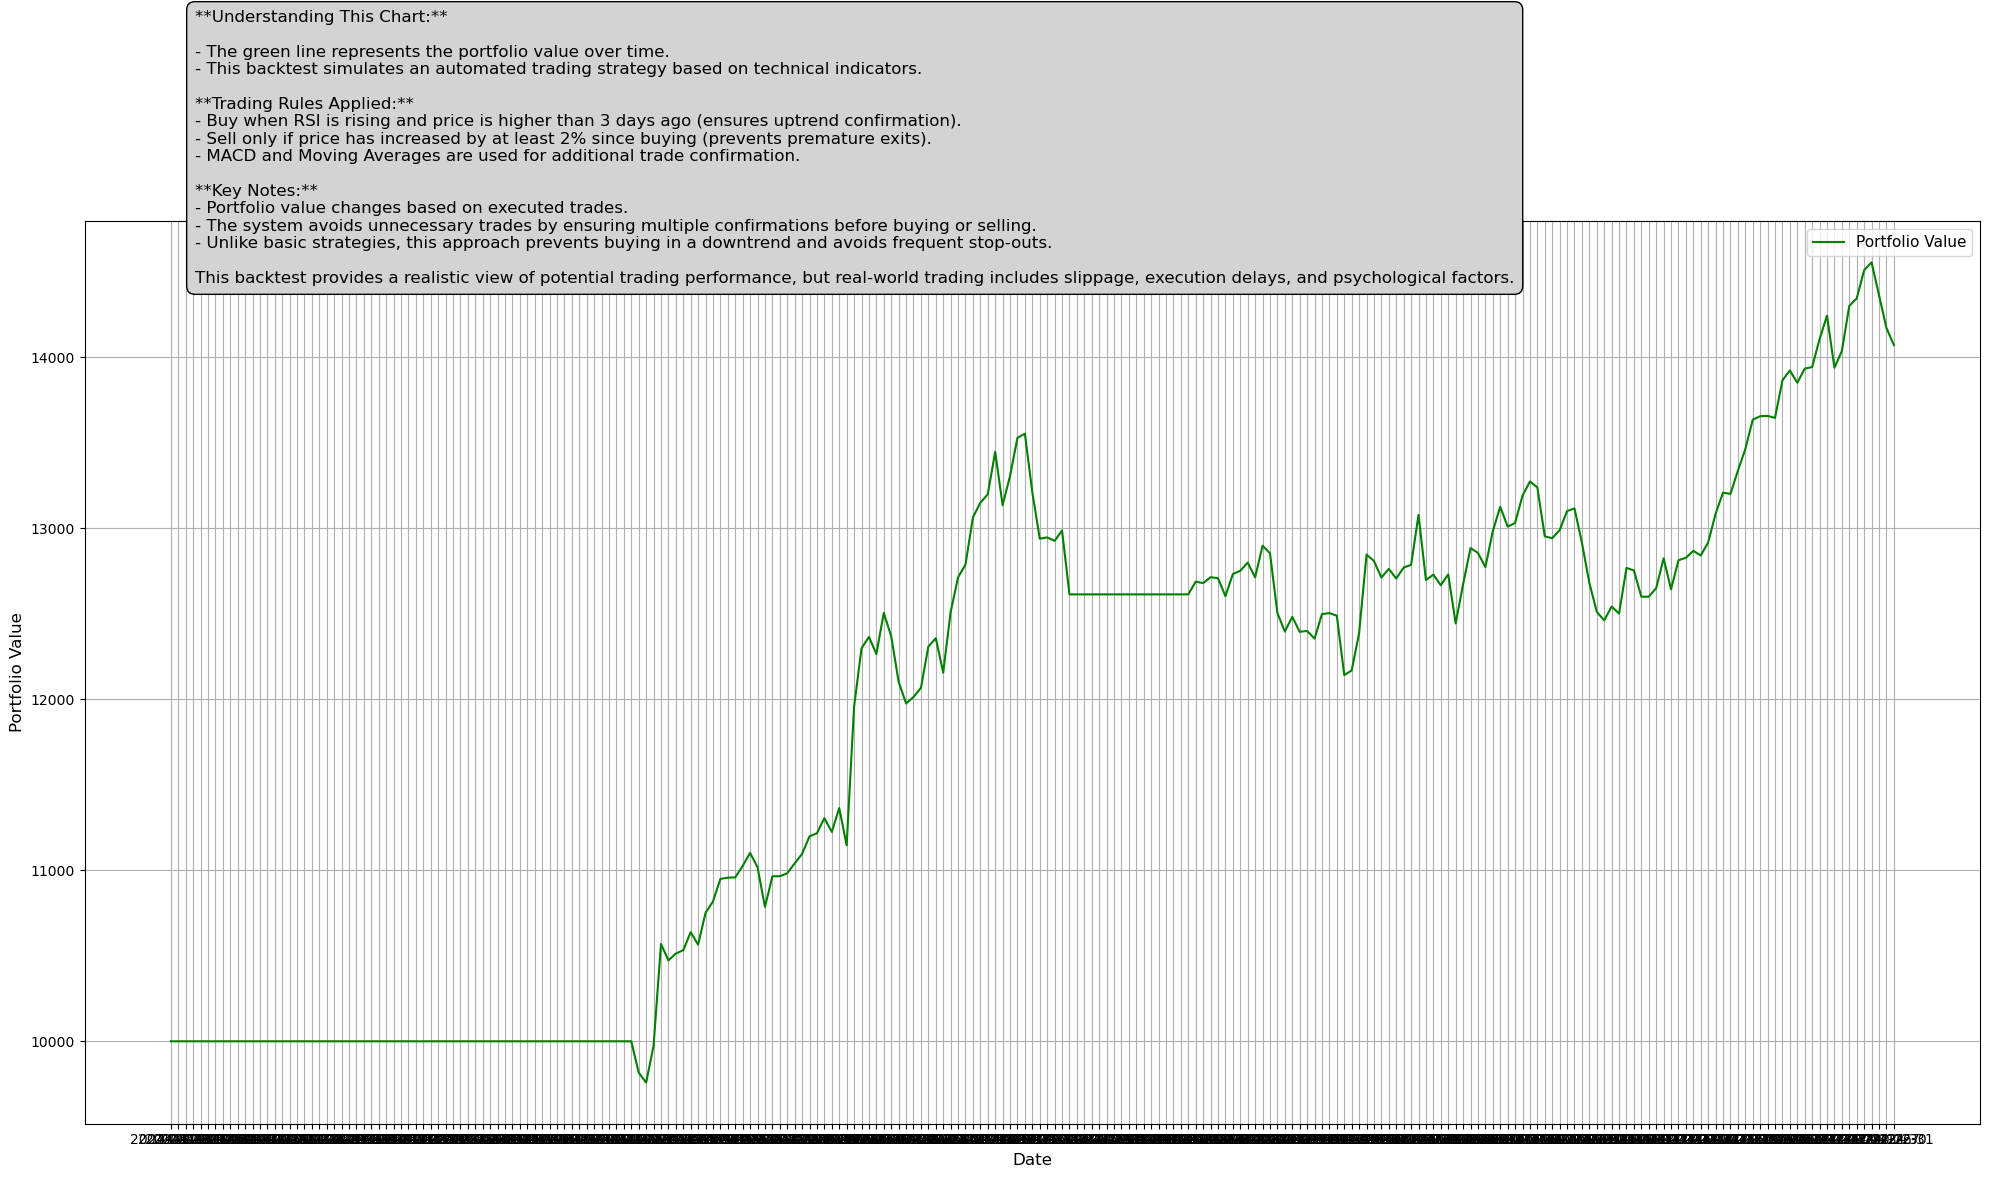

In [7]:
# Initialize plotter
plotter = StockPlotter(stock_data, ticker)

# Generate figures and save them
fig1 = plotter.plot_closing_price()
pdf_pages.savefig(fig1)  # Save Closing Price plot

fig2 = plotter.plot_rsi()
pdf_pages.savefig(fig2)  # Save RSI plot

fig3 = plotter.plot_macd()
pdf_pages.savefig(fig3)  # Save MACD plot

# Initialize Backtest Strategy
backtest_strategy = BacktestStrategy("Advanced Strategy")

# Generate backtest results
backtest_results = backtest_strategy.run_backtest(df)
fig4 = plotter.plot_backtest_results(backtest_results)
pdf_pages.savefig(fig4)  # Save Backtest plot

In [8]:
n_features = X_train.shape[2]
lstm_model = Models.LSTM_Model(sequence_length, n_features)

# Train the model
history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1)

# Make predictions
#y_pred_lstm = lstm_model.predict(X_test).flatten()
y_pred_lstm = lstm_model.predict(X_test)
print(y_pred_lstm)# Get predictions in scaled format
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten() # Convert back to real prices for MaxScaler
print(y_pred_lstm)
print(y_test)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.8334 - val_loss: 0.2510
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2061 - val_loss: 0.2130
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2025 - val_loss: 0.1432
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0965 - val_loss: 0.1534
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0992 - val_loss: 0.1047
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1266 - val_loss: 0.0794
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0772 - val_loss: 0.0955
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0859 - val_loss: 0.0181
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0669 - val_loss: 0.0367
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0869 - val_loss: 0.0715
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0357 - val_loss: 0.1016
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

In [9]:
print(f"Number of Features in X_train: {n_features}")
print("Shape of X_train:", X_train.shape)

Number of Features in X_train: 11
Shape of X_train: (174, 15, 11)


In [11]:
xgb_model = Models.XGB_Model(n_estimators=150, max_depth=8, learning_rate=0.05, gamma=0.3, subsample=0.9)

xgb_model.summary()  # ✅ Now the method exists and will print model details

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
y_pred_xgb = predictions.flatten()



📌 **XGBoost Model Summary**
 - n_estimators: 150
 - max_depth: 8
 - learning_rate: 0.05
 - Other Parameters: {'gamma': 0.3, 'subsample': 0.9}
 - Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_meth

In [12]:
gp_model = Models.GP_Model()
gp_model.fit(X_train, y_train)

# Predict with confidence intervals
y_pred_gp, sigma_gp = gp_model.predict(X_test, return_std=True)

Optimized Kernel: 0.705**2 * Matern(length_scale=26, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Model: LSTM
MSE: 0.0382
MAE: 0.1548
R²: -1.2129
Direction: 0.4857

Model: XGBoost
MSE: 0.0436
MAE: 0.1704
R²: -1.8647
Direction: 0.0465

Model: Gaussian Process
MSE: 0.0266
MAE: 0.1178
R²: -0.7482
Direction: 0.4419
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
44


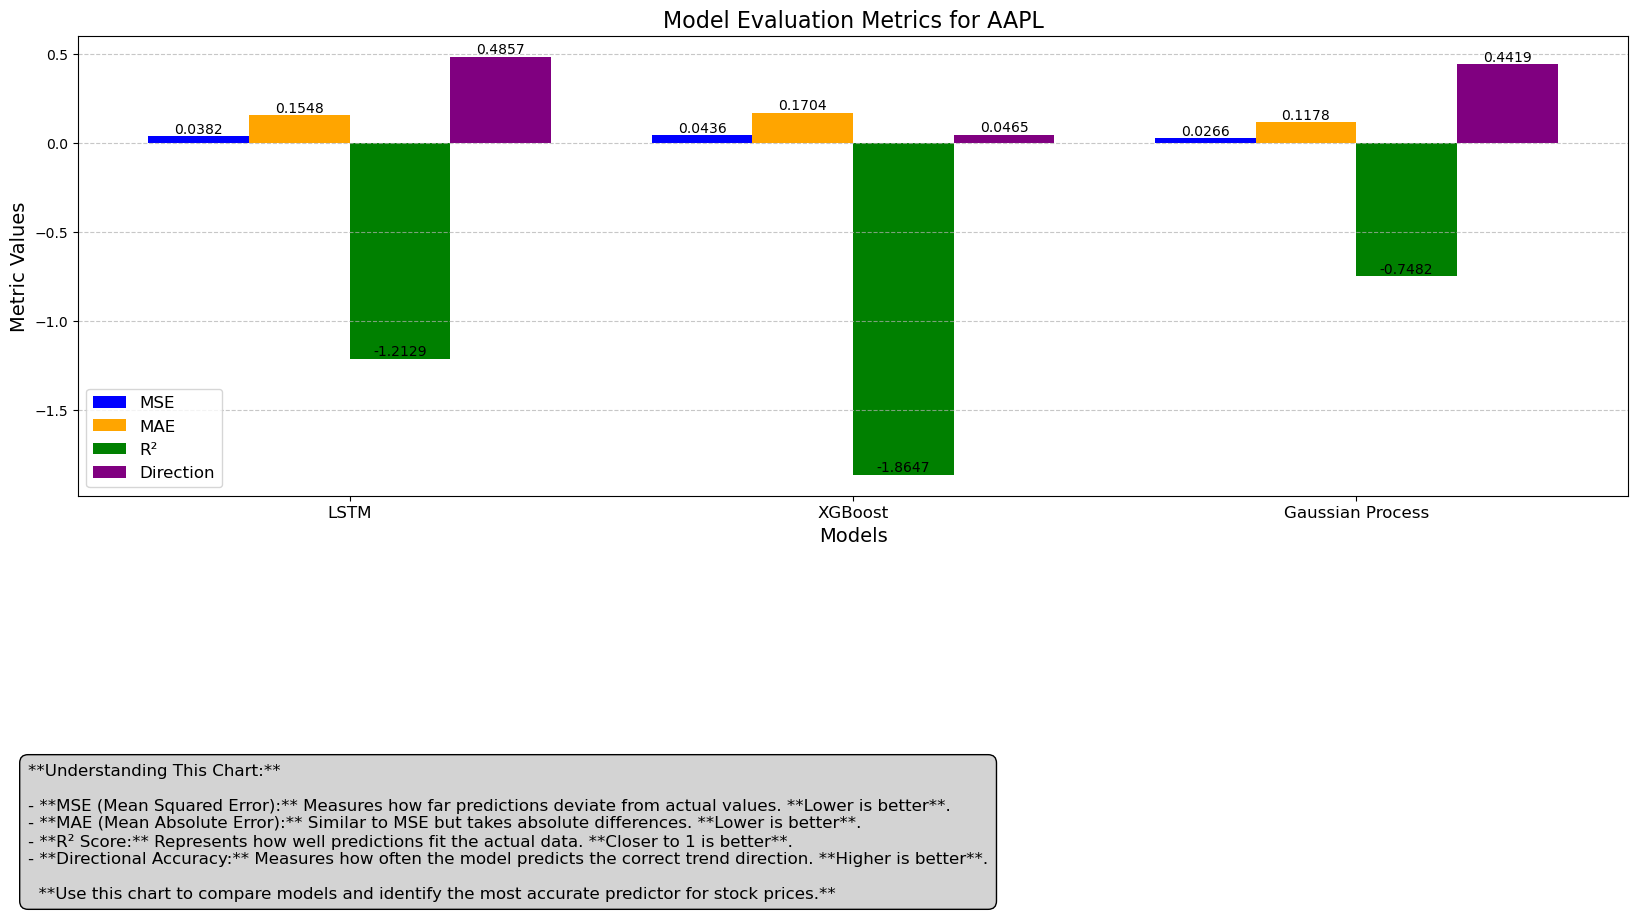

In [13]:
models = {
    'LSTM': lstm_model,
    'XGBoost': xgb_model,
    'Gaussian Process': y_pred_gp
}
evaluator = ModelEvaluator(models, X_test, y_test, ticker)

# Evaluate models
evaluation_results, y_predictions = evaluator.evaluate()

# Print results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

fig2 = evaluator.plot_metrics()
pdf_pages.savefig(fig2)
print(len(X_test))

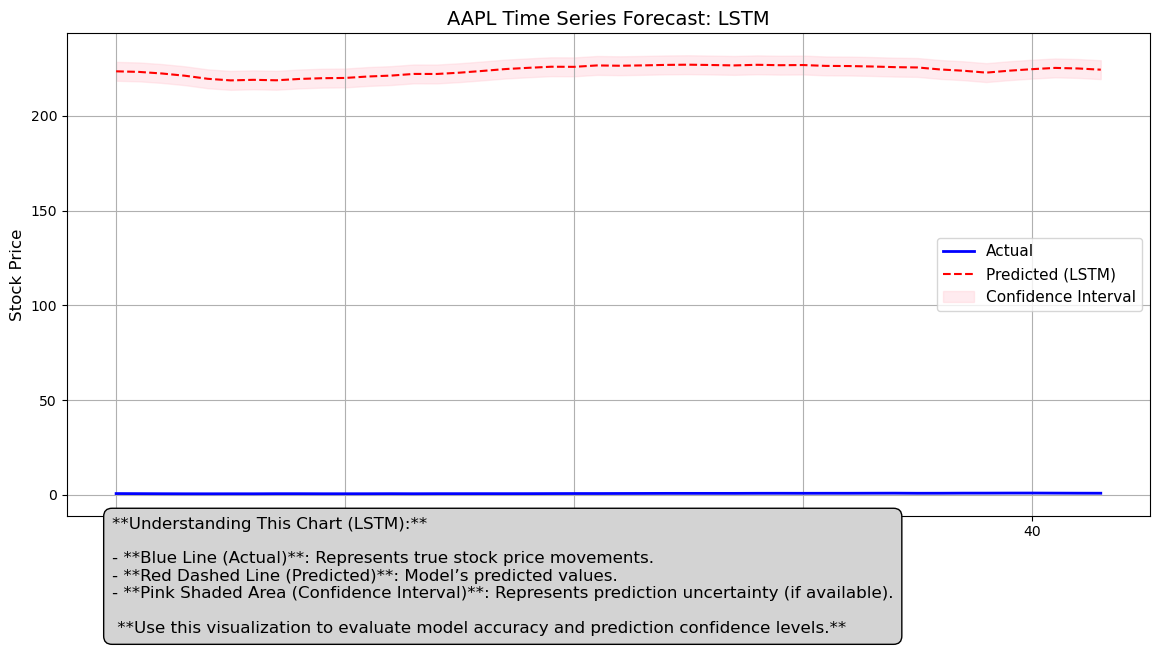

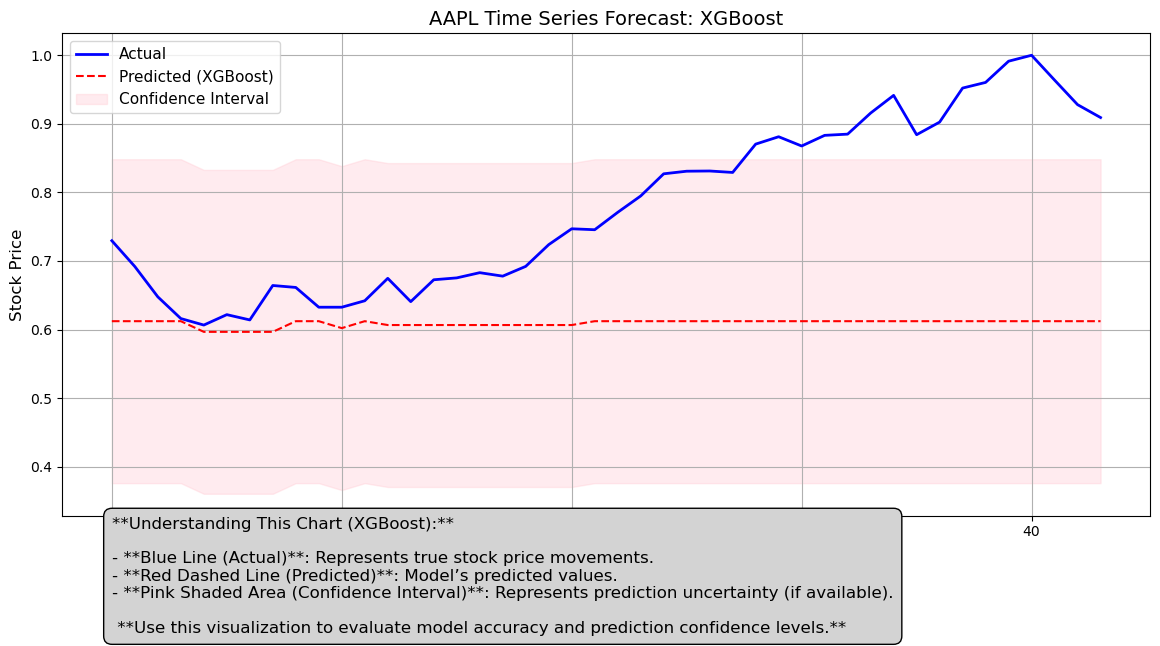

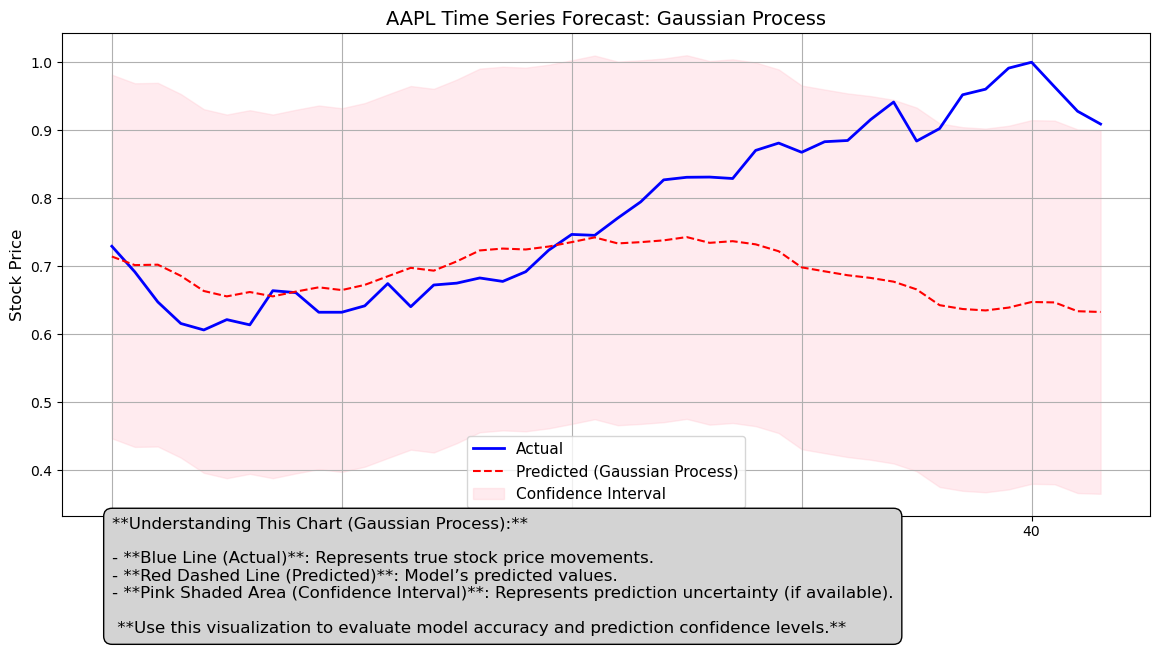

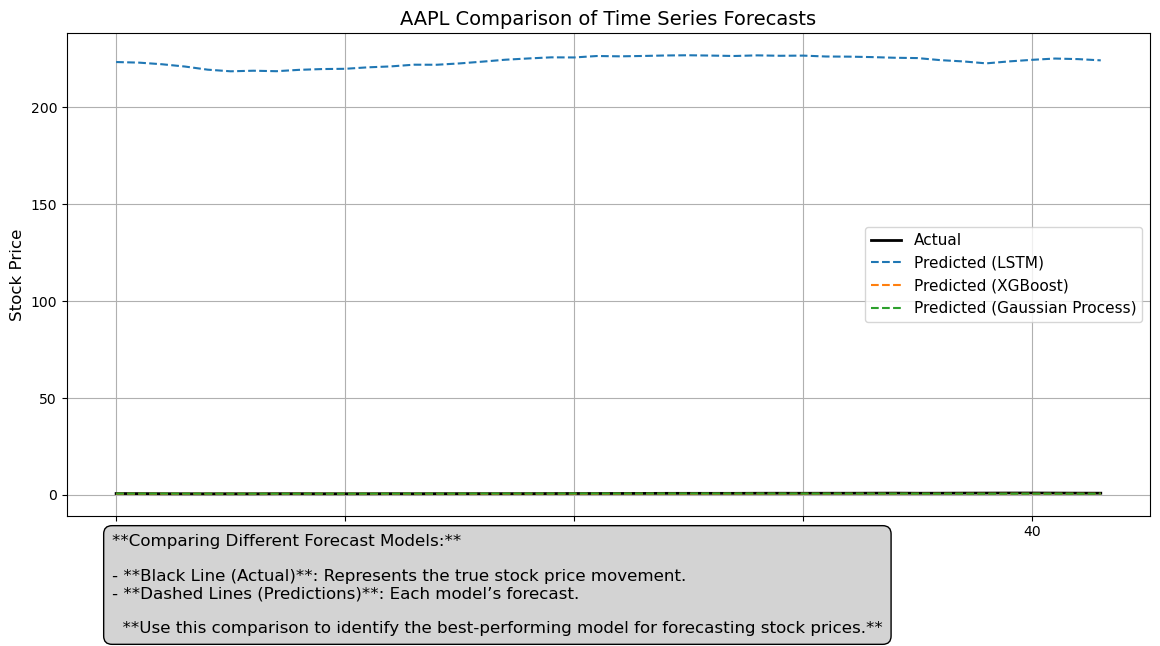

In [14]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file
pdf_pages = PdfPages("time_series_plots.pdf")

# Ensure std_devs exists
std_devs = {}  
if 'sigma_gp' in globals():
    std_devs['GP'] = sigma_gp

# Predictions dictionary
predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'Gaussian Process': y_pred_gp
}

# Initialize visualizer
visualizer = TimeSeriesVisualizer(y_test, predictions, ticker, std_devs)

# Generate separate plots for each model and save them
figs = visualizer.plot_predictions()
for fig in figs:
    pdf_pages.savefig(fig)

# Generate and save the comparison plot
fig_compare = visualizer.compare_models()
pdf_pages.savefig(fig_compare)

Backtest results for LSTM saved to PDF (Page 6).


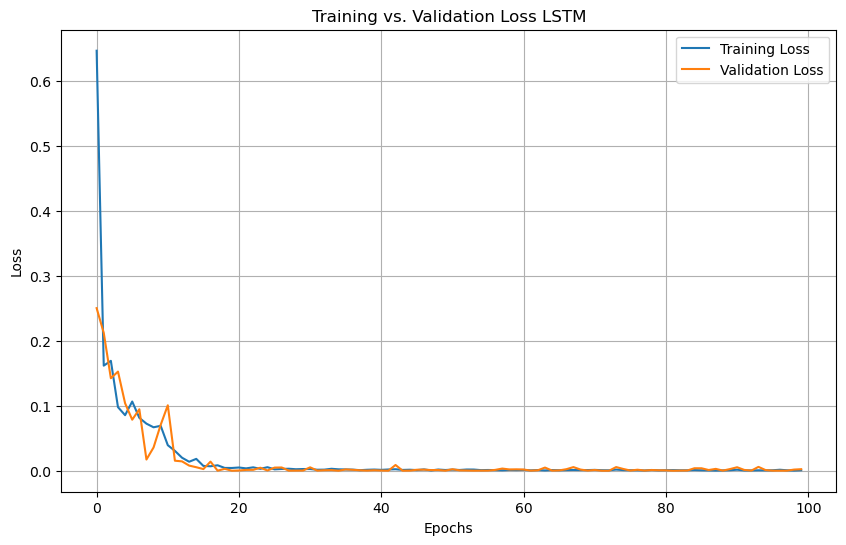

In [15]:
fig6 = utils.plot_training_history(history_lstm)  # Call only once and store result

if fig6 is not None:  # Ensure fig7 is valid before saving
    pdf_pages.savefig(fig6)
    print("Backtest results for LSTM saved to PDF (Page 6).")
else:
    print("Error: plot_training_history did not return a figure.")

Backtest results for XGBoost saved to PDF (Page 7).


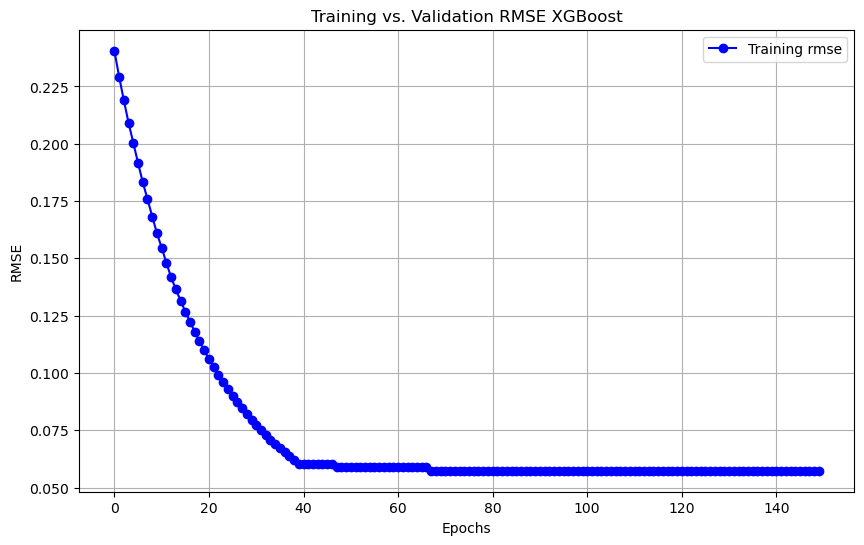

In [16]:
fig7 = xgb_model.plot_training_history(metric="rmse")
#fig7 = utils.plot_training_history(history_lstm)  # Call only once and store result

if fig7 is not None:  # Ensure fig7 is valid before saving
    pdf_pages.savefig(fig7)
    print("Backtest results for XGBoost saved to PDF (Page 7).")
else:
    print("Error: plot_training_history did not return a figure.")

C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 0.773**2 * Matern(length_scale=28.2, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm

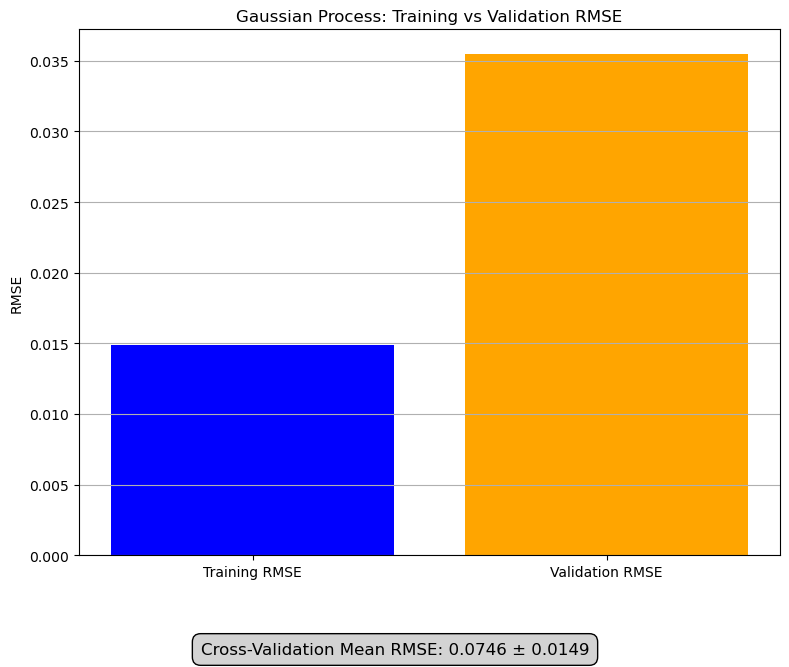

In [17]:
#gp_model = GaussianProcessModel()
fig8 = gp_model.validate(X_train, y_train)
pdf_pages.savefig(fig8)  # ✅ Save to PDF

In [18]:
# Close the PDF file
pdf_pages.close()
print("PDF successfully closed")

#Falls nur ein Teill von Code wird ausgefuert und kein pdf erzeugt wird, sonst Fehlermeldung
pdf_pages = PdfPages("output.pdf")

if pdf_pages.get_pagecount() > 0:  # Direkter Vergleich ohne len()
    pdf_pages.close()
else:
    pdf_pages._file.close()  # Datei korrekt schließen, um die Warnung zu vermeiden

PDF successfully closed
